In [40]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [41]:
# Environment Setup
# 0: empty, 1: wall, 2: box, 3: storage, 4: agent
grid = np.array([
    [1, 1, 1, 1, 1, 1],
    [1, 0, 4, 1, 1, 1],
    [1, 0, 0, 1, 1, 1],
    [1, 3, 0, 0, 0, 1],
    [1, 0, 0, 2, 0, 1],
    [1, 0, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 1],
])

# State is a tuple: (agent_position, box_positions)
initial_agent_pos = (1, 2)
initial_box_pos = [(4, 3)]
storage_pos = [(3, 1)]

In [42]:
# Constants
GRID_ROWS = 7
GRID_COLS = 6
ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
DISCOUNT_FACTOR = 0.9
THRESHOLD = 1e-4
MAX_ITERATIONS = 1000

# Initialize Value Function and Policy
V = {}
policy = {}

In [43]:
# Helper functions
def is_valid_position(pos):
    """ Check if the position is within bounds and not a wall. """
    row, col = pos
    return 0 <= row < GRID_ROWS and 0 <= col < GRID_COLS and grid[row, col] != 1

def move_agent(agent_pos, action):
    """ Get new agent position after performing the action. """
    row, col = agent_pos
    if action == 'UP':
        return (row - 1, col)
    elif action == 'DOWN':
        return (row + 1, col)
    elif action == 'LEFT':
        return (row, col - 1)
    elif action == 'RIGHT':
        return (row, col + 1)

def apply_action(agent_pos, box_pos, action):
    """ Simulate the effect of an action on the environment. """
    new_agent_pos = move_agent(agent_pos, action)

    # If it's a valid move and not onto a box
    if is_valid_position(new_agent_pos) and new_agent_pos not in box_pos:
        return new_agent_pos, box_pos

    # If it's a box, try to push it
    if new_agent_pos in box_pos:
        new_box_pos = move_agent(new_agent_pos, action)
        if is_valid_position(new_box_pos) and new_box_pos not in box_pos:
            # Update the box's position
            new_box_pos_list = [new_box_pos if pos == new_agent_pos else pos for pos in box_pos]
            return new_agent_pos, new_box_pos_list

    # If move is not valid, return the current state
    return agent_pos, box_pos

def is_terminal(box_pos):
    """ Check if all boxes are in storage locations. """
    return all(pos in storage_pos for pos in box_pos)

def reward(box_pos):
    """ Reward is -1 for every step unless all boxes are in storage locations. """
    return 0 if is_terminal(box_pos) else -1

# Value Iteration

In [44]:
def value_iteration():
    for _ in range(MAX_ITERATIONS):
        delta = 0
        for agent_pos in [(r, c) for r in range(GRID_ROWS) for c in range(GRID_COLS)]:
            if not is_valid_position(agent_pos):
                continue
            for box_pos in [(r, c) for r in range(GRID_ROWS) for c in range(GRID_COLS)]:
                if not is_valid_position(box_pos) or box_pos == agent_pos:
                    continue

                if is_terminal([box_pos]):
                    continue
                state = (agent_pos, box_pos)
                old_value = V.get(state, 0)
                new_value = float('-inf')

                # Iterate over possible actions
                for action in ACTIONS:
                    new_agent_pos, new_box_pos = apply_action(agent_pos, [box_pos], action)
                    next_state = (new_agent_pos, new_box_pos[0])
                    value = reward(new_box_pos) + DISCOUNT_FACTOR * V.get(next_state, 0)
                    new_value = max(new_value, value)

                # Update value function
                V[state] = new_value
                delta = max(delta, abs(old_value - new_value))

        # If change is below threshold, stop
        if delta < THRESHOLD:
            break

value_iteration()

# Policy Extraction

In [45]:
def extract_policy():
    for agent_pos in [(r, c) for r in range(GRID_ROWS) for c in range(GRID_COLS)]:
        if not is_valid_position(agent_pos):
            continue
        for box_pos in [(r, c) for r in range(GRID_ROWS) for c in range(GRID_COLS)]:
            if not is_valid_position(box_pos) or box_pos == agent_pos:
                continue

            if is_terminal([box_pos]):
                continue
            state = (agent_pos, box_pos)
            best_action = None
            best_value = float('-inf')

            # Find the best action
            for action in ACTIONS:
                new_agent_pos, new_box_pos = apply_action(agent_pos, [box_pos], action)
                next_state = (new_agent_pos, new_box_pos[0])
                value = reward(new_box_pos) + DISCOUNT_FACTOR * V.get(next_state, 0)

                if value > best_value:
                    best_value = value
                    best_action = action

            policy[state] = best_action

extract_policy()

In [46]:
def print_value_function():
    """ Prints the value function in grid form for visualization """
    value_grid = np.zeros((GRID_ROWS, GRID_COLS))

    for agent_pos in [(r, c) for r in range(GRID_ROWS) for c in range(GRID_COLS)]:
        if not is_valid_position(agent_pos):
            continue
        for box_pos in [(r, c) for r in range(GRID_ROWS) for c in range(GRID_COLS)]:
            if not is_valid_position(box_pos) or box_pos == agent_pos:
                continue
            state = (agent_pos, box_pos)
            value_grid[agent_pos[0], agent_pos[1]] = V.get(state, 0)

    print("Dynamic Programming Optimal Value Function:")
    print(value_grid)

print_value_function()

Dynamic Programming Optimal Value Function:
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.         -9.99915359 -9.99915359  0.          0.          0.        ]
 [ 0.         -9.99915359 -9.99915359  0.          0.          0.        ]
 [ 0.         -9.99915359 -9.99915359 -9.99915359 -9.99915359  0.        ]
 [ 0.         -9.99915359 -9.99915359 -9.99915359 -9.99915359  0.        ]
 [ 0.         -9.99915359 -9.99915359  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]


# Visualization

In [47]:
def visualize_grid(agent_pos, box_pos):
    # Start with a fresh copy of the grid (reset)
    vis_grid = np.copy(grid)

    # Place boxes in their new positions
    for pos in box_pos:
        vis_grid[pos] = 2  # Box

    # Place the agent in its new position
    vis_grid[agent_pos] = 4  # Agent

    # Display the grid
    plt.imshow(vis_grid, cmap='Pastel1')
    plt.grid(True)
    plt.xticks(range(GRID_COLS))
    plt.yticks(range(GRID_ROWS))
    plt.pause(0.5)
    plt.show()


In [48]:
# Simulate following the policy
def simulate():
    agent_pos = initial_agent_pos
    box_pos = initial_box_pos
    plt.ion()  # Enable interactive mode

    # Store the previous positions
    previous_agent_pos = agent_pos
    previous_box_pos = box_pos

    while not is_terminal(box_pos):
        # Clear previous agent and box positions
        grid[previous_agent_pos] = 0  # Set the previous agent position to empty
        for pos in previous_box_pos:
            grid[pos] = 0  # Set previous box positions to empty

        # Visualize the updated grid with cleared previous positions
        visualize_grid(agent_pos, box_pos)

        # Update the previous positions
        previous_agent_pos = agent_pos
        previous_box_pos = box_pos

        # Get current state and policy action
        state = (agent_pos, box_pos[0])
        action = policy.get(state)

        if action is None:
            print("No valid action found. Terminating.")
            break

        # Apply the action to get new positions
        agent_pos, box_pos = apply_action(agent_pos, box_pos, action)
        time.sleep(1)

    visualize_grid(agent_pos, box_pos)
    print("Solved the Sokoban puzzle!" if is_terminal(box_pos) else "Failed.")


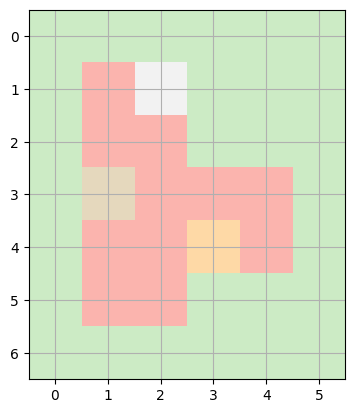

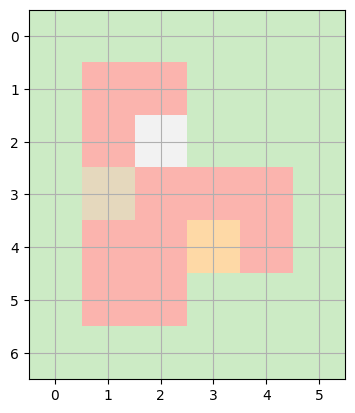

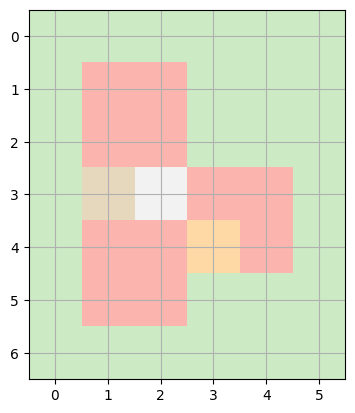

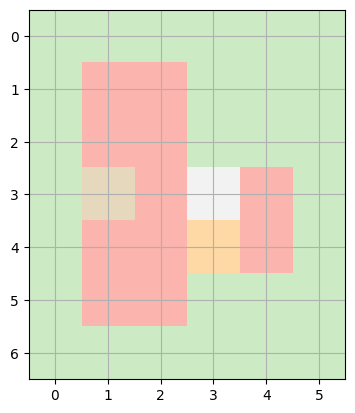

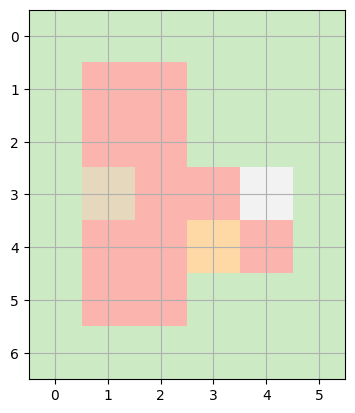

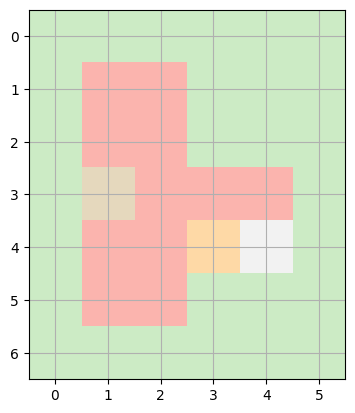

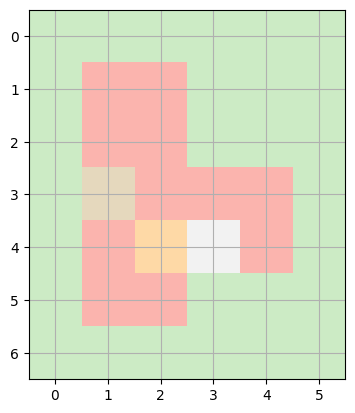

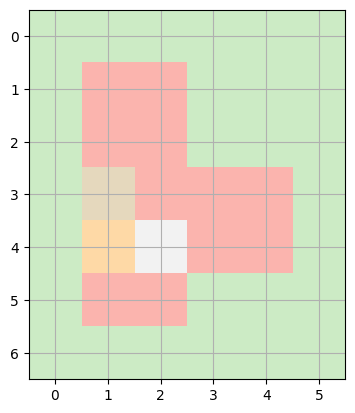

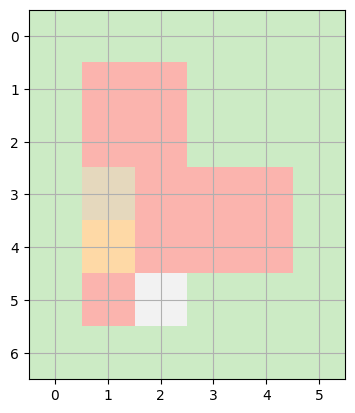

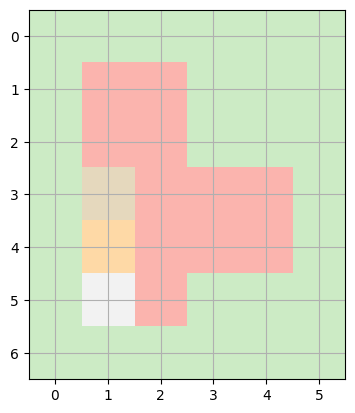

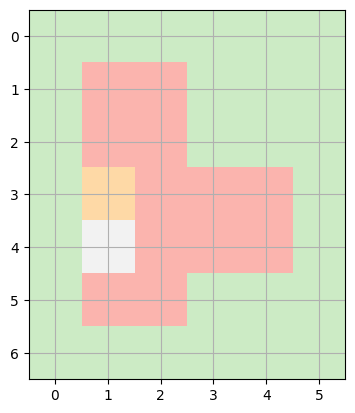

Solved the Sokoban puzzle!


In [49]:
simulate()